Blankenbach Benchmark Case 2a
======

Temperature dependent convection
----

This is a benchmark case of two-dimensional, incompressible, bottom heated, temperature dependent convection. This example is based on case 2a in Blankenbach *et al.* 1989 for a single Rayleigh number ($Ra = 10^7$).

Here a temperature field that is already in equilibrium is loaded and a single Stokes solve is used to get the velocity and pressure fields. A few advection time steps are carried out as a demonstration of the new viscosity function.

**This lesson introduces the concepts of:**
1. material rheologies with functional dependencies

**Keywords:** Stokes system, advective diffusive systems, analysis tools, tools for post analysis, rheologies


**References**

1. B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [1]:
%matplotlib inline
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

Setup parameters
-----

Set simulation parameters for test.

In [2]:
Temp_Min = 0.0
Temp_Max = 1.0
res = 128

**Set physical values in SI units**

In [3]:
alpha = 2.5e-5
rho   = 4e3
g     = 10
dT    = 1e3
h     = 1e6
kappa = 1e-6
eta   = 2.5e19

**Set viscosity function constants as per Case 2a**

In [4]:
Ra   = 1e7
eta0 = 1.0e3

**Input file path**


Set input directory path

In [5]:
inputPath  = 'BBInput/'

Create mesh and finite element variables
------

In [6]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

Initial conditions
-------

Load an equilibrium case with 128$\times$128 resolution and $Ra = 10^7$. This can be changed as per **1_03_BlankenbachBenchmark** if required.

In [7]:
meshOld = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                    elementRes  = (128, 128), 
                                    minCoord    = (0., 0.), 
                                    maxCoord    = (1., 1.))
temperatureFieldOld = uw.mesh.MeshVariable( mesh=meshOld, nodeDofCount=1 )        
temperatureFieldOld.load( inputPath + 'tempfield_case2_128_Ra1e7_10000.h5' )

temperatureField.data[:]    = temperatureFieldOld.evaluate( mesh )
temperatureDotField.data[:] = 0.
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.

**Plot initial temperature**


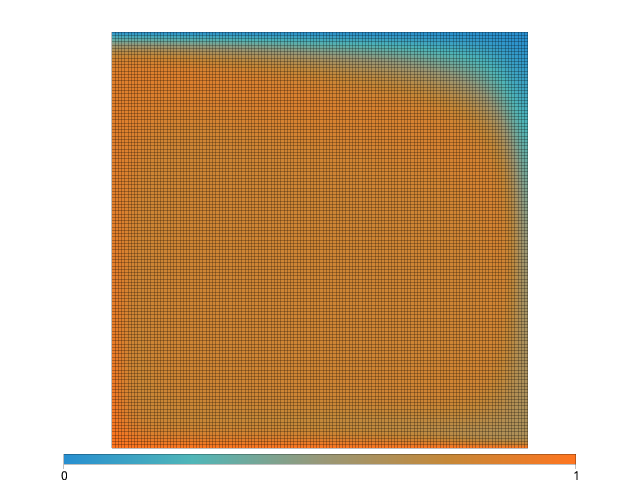

In [8]:
figtemp = glucifer.Figure()
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField) )
figtemp.show()

**Boundary conditions**

In [9]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = Temp_Max
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = Temp_Min
    
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = ( jWalls, ) )

Set up material parameters and functions
-----

Setup the viscosity to be a function of the temperature. Recall that these functions and values are preserved for the entire simulation time. 

In [10]:
b = math.log(eta0)
T = temperatureField
fn_viscosity = eta0 * fn.math.exp( -1.0 * b * T )

densityFn = Ra*temperatureField
gravity = ( 0.0, 1.0 )
buoyancyFn = gravity*densityFn

**Plot the initial viscosity**

Plot the viscosity, which is a function of temperature, using the initial temperature conditions set above.


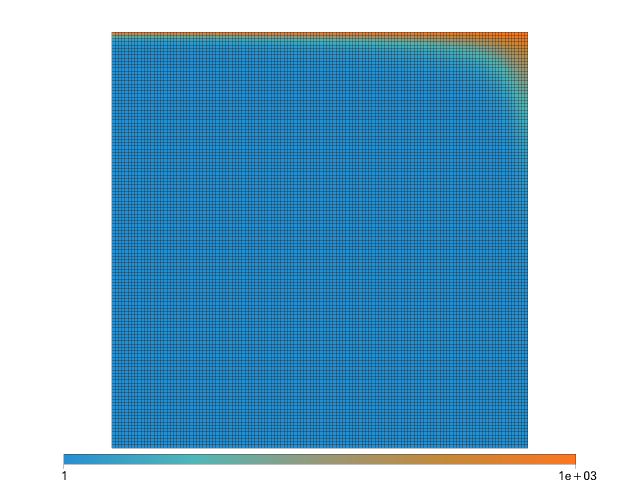

In [11]:
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Mesh(mesh) )
figEta.append( glucifer.objects.Surface(mesh, fn_viscosity) )
figEta.show()

System setup
-----

Since we are using a previously constructed temperature field, we will use a single Stokes solve to get consistent velocity and pressure fields.

**Setup a Stokes system**

In [12]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=fn_viscosity, 
                              fn_bodyforce=buoyancyFn )

**Set up and solve the Stokes system**

In [13]:
solver = uw.systems.Solver(stokesPIC)
solver.solve()

**Create an advective diffusive system**

In [14]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField, velocityField, fn_diffusivity = 1., 
                                         conditions = [tempBC,], )

Analysis tools
-----

**Nusselt number**

In [15]:
nuTop      = uw.utils.Integral( fn=temperatureField.fn_gradient[1], mesh=mesh, integrationType='Surface', 
                                surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
Nu = -nuTop.evaluate()[0]
print('Initial Nusselt number = {0:.3f}'.format(Nu))

Initial Nusselt number = 10.028


**RMS velocity**

In [16]:
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=fn.math.dot( velocityField, velocityField ) )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )
Vrms = math.sqrt( v2sum_integral.evaluate()[0] )/volume_integral.evaluate()[0]
print('Initial Vrms = {0:.3f}'.format(Vrms))

Initial Vrms = 481.351


**Temperature gradients at corners**

In [17]:
def calcQs():
    return (-1.0 * temperatureField.fn_gradient[1].evaluate( (0., 1.))[0][0],
           -1.0 * temperatureField.fn_gradient[1].evaluate( (1., 1.))[0][0],
           -1.0 * temperatureField.fn_gradient[1].evaluate( (1., 0.))[0][0],
           -1.0 * temperatureField.fn_gradient[1].evaluate( (0., 0.))[0][0])

In [18]:
q1, q2, q3, q4 = calcQs()
print('Initial T gradients = {0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}'.format(q1, q2, q3, q4))

Initial T gradients = 17.435, 1.007, 24.819, 0.485


Main simulation loop
-----

Run a few advection and Stokes solver steps to make sure we are in, or close to, equilibrium.

In [19]:
time = 0.
step = 0
steps_end = 4

In [20]:
while step < steps_end:
    # solve Stokes and advection systems
    solver.solve()
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    # Calculate the RMS velocity and Nusselt number.
    Vrms = math.sqrt( v2sum_integral.evaluate()[0] )/volume_integral.evaluate()[0]
    Nu = -nuTop.evaluate()[0]
    q1, q2, q3, q4 = calcQs()
    print('Step {0:2d}: Vrms = {1:.3f}; Nu = {2:.3f}; q1 = {3:.3f}; q2 = {4:.3f}; q3 = {5:.3f}; q4 = {6:.3f}'
          .format(step, Vrms, Nu, q1, q2, q3, q4))
    time += dt
    step += 1

Step  0: Vrms = 481.351; Nu = 10.028; q1 = 17.435; q2 = 1.007; q3 = 24.819; q4 = 0.485
Step  1: Vrms = 481.351; Nu = 10.028; q1 = 17.435; q2 = 1.007; q3 = 24.820; q4 = 0.485
Step  2: Vrms = 481.351; Nu = 10.028; q1 = 17.435; q2 = 1.007; q3 = 24.821; q4 = 0.485
Step  3: Vrms = 481.352; Nu = 10.028; q1 = 17.435; q2 = 1.007; q3 = 24.821; q4 = 0.485


Comparison of benchmark values
-----

Compare values from Underworld against those from Blankenbach *et al.* 1989 for case 2a in the table below. 

In [21]:
print('Nu   = {0:.3f}'.format(Nu))
print('Vrms = {0:.3f}'.format(Vrms))
print('q1   = {0:.3f}'.format(q1))
print('q2   = {0:.3f}'.format(q2))
print('q3   = {0:.3f}'.format(q3))
print('q4   = {0:.3f}'.format(q4))

Nu   = 10.028
Vrms = 481.352
q1   = 17.435
q2   = 1.007
q3   = 24.821
q4   = 0.485



| $Ra$   | $Nu$    | $v_{rms}$|  $q_1$   |  $q_2$  |  $q_3$  |  $q_4$   | 
|:------:|:--------:|:-------:|:--------:|:-------:|:-------:|:--------:|
| 10$^7$ | 10.0660 | 480.4    | 17.53136 | 1.00851 | 26.8085 | 0.497380 | 